# CFPB Customer Complait Issue

## Model Building

### 1. Import packages

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Basic operations
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Machine learning
import lightgbm as lgb
import xgboost as xgb

# Sklearn package sets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
#from sklearn.metrics import roc_curve
#from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression

# Timer
import time


/Users/yangtian/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 2. Load Data

In [2]:
data = pd.read_csv('./data_for_tree.csv')
data.shape

(860606, 278)

In [3]:
data.head(3)

,Is_Timely_response,Is_Consumer_disputed,days_spend,year,month,mean_rate_by_time,mean_rate_over_avg_by_time,complaint_scale,mean_response_rate_by_Company,mean_response_rate_over_avg_by_Company,...,State_WA,State_WI,State_WV,State_WY,Submitted_via_Email,Submitted_via_Fax,Submitted_via_Phone,Submitted_via_Postal mail,Submitted_via_Referral,Submitted_via_Web
0,1,0,5.0,2014,3,0.984378,0.011944,4.0,0.987044,0.015024,...,0,0,0,0,0,0,0,0,1,0
1,1,0,4.0,2014,6,0.978667,0.006233,4.0,0.987044,0.015024,...,0,0,0,0,0,1,0,0,0,0
2,1,0,4.0,2014,11,0.969955,-0.002479,4.0,0.987044,0.015024,...,0,0,0,0,0,1,0,0,0,0


In [4]:
train_len = int(data.shape[0] * 0.7)
train_len

602424

** Split training, validation and test set **

- training set: 70%
- validation set: 15%
- test set: 15%

** Set Seed **

In [7]:
# global seed
rs = 20171101
np.random.seed(rs)

In [8]:
train_len = int(data.shape[0] * 0.85)

train = data.iloc[:train_len,:]
test = data.iloc[train_len: ,:]

print('Training set shape:', train.shape)
print('Test set shape:', test.shape)

Training set shape: (731515, 278)
Test set shape: (129091, 278)


In [9]:
label = train.Is_Timely_response
del train['Is_Timely_response']

X_train, X_val, y_train, y_val = train_test_split(
    train, label, 
    test_size = 0.15, 
    random_state = rs)

print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)

X_train shape: (621787, 277)
X_val shape: (109728, 277)
y_train shape: (621787,)
y_val shape: (109728,)


### 3. Model Building

** Light GBM **

In [33]:
sens=[]
accu=[]
for rounds in [600,800,1000,1200,1400,1600,1800,2000,2200,2400]:
    param  = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting': 'gbdt',
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'feature_fraction_seed': rs,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'bagging_seed': rs,
    'num_boost_round': rounds
    }
    
    start_time = time.time()

    data_lgb = lgb.Dataset(X_train, y_train)
    lgbm = lgb.train(param, data_lgb)
    pred = lgbm.predict(X_val)

    pred[pred > 0.5] = 1
    pred[pred < 0.5] = 0

    conf_mat = confusion_matrix(y_val, pred)
    acc = (conf_mat[0][0] + conf_mat[1][1])/len(y_val)
    sen = conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1])

    print('Round = %i:'%rounds)
    print('======================')
    print('Accuracy:', acc)

    sen = conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1])
    print('Sensitivity:', sen)
    print('Running time:', (time.time() - start_time))
    print('')
    
    sens.append(sen)
    accu.append(acc)

Round = 600:
Accuracy: 0.980715952173
Sensitivity: 0.400341296928
Running time: 39.864089012145996

Round = 800:
Accuracy: 0.980788859726
Sensitivity: 0.404436860068
Running time: 48.89823913574219

Round = 1000:
Accuracy: 0.980761519393
Sensitivity: 0.404778156997
Running time: 56.01082706451416

Round = 1200:
Accuracy: 0.980870880723
Sensitivity: 0.407508532423
Running time: 62.878029108047485

Round = 1400:
Accuracy: 0.980934674832
Sensitivity: 0.41023890785
Running time: 68.13631200790405

Round = 1600:
Accuracy: 0.980971128609
Sensitivity: 0.412627986348
Running time: 78.25528693199158

Round = 1800:
Accuracy: 0.980998468941
Sensitivity: 0.414675767918
Running time: 88.11366200447083

Round = 2000:
Accuracy: 0.980943788276
Sensitivity: 0.414675767918
Running time: 101.53858518600464

Round = 2200:
Accuracy: 0.980898221056
Sensitivity: 0.411604095563
Running time: 113.58572316169739

Round = 2400:
Accuracy: 0.980816200058
Sensitivity: 0.411945392491
Running time: 117.69336605072021

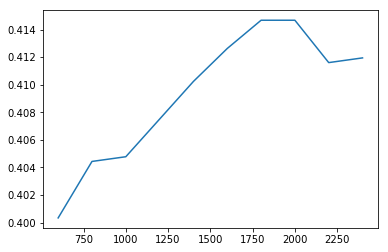

In [37]:
rounds = [600,800,1000,1200,1400,1600,1800,2000,2200,2400]

plt.plot(rounds,sens)
#plt.plot(rounds,accu)
plt.show()

In [38]:
rounds = 1800

param  = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting': 'gbdt',
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'feature_fraction_seed': rs,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'bagging_seed': rs,
    'num_boost_round': rounds
}

In [39]:
start_time = time.time()

data_lgb = lgb.Dataset(X_train, y_train)
lgbm = lgb.train(param, data_lgb)
pred = lgbm.predict(X_val)

print("### %s seconds ###" % (time.time() - start_time))

### 91.08968210220337 seconds ###


** CV?? **

In [29]:
start_time = time.time()

data_lgbm_cv = lgb.Dataset(train, label)
lgbm_cv = lgb.cv(param, data_lgbm_cv, num_boost_round=100, nfold=10)

print("### %s seconds ###" % (time.time() - start_time))

### 91.35066390037537 seconds ###


In [30]:
len(lgbm_cv['binary_logloss-mean'])

100

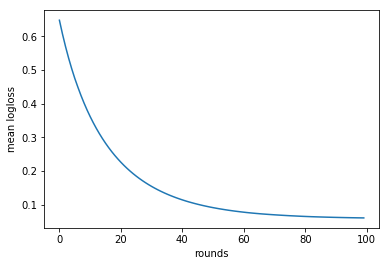

In [32]:
logloss = lgbm_cv['binary_logloss-mean']
x = range(100)

plt.plot(x,logloss)
plt.xlabel('boost rounds')
plt.ylabel('mean logloss')
plt.show()

** ROC **

How much is the model better than random guess. 

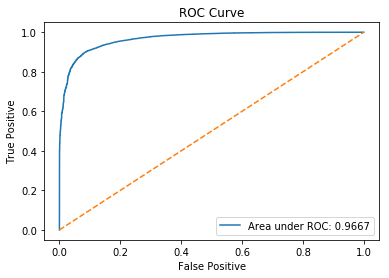

In [41]:
fp, tp, thr = roc_curve(y_val, pred)
score = roc_auc_score(y_val,pred)

plt.plot(fp, tp, label='Area under ROC: %0.4f'%score)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.plot([0, 1], [0, 1], linestyle='--')

plt.show()

** Accuracy and Sensitivity **

In [42]:
pred[pred > 0.5] = 1
pred[pred < 0.5] = 0

conf_mat = confusion_matrix(y_val, pred)
acc = (conf_mat[0][0] + conf_mat[1][1])/len(y_val)
print('Accuracy:', acc)

sen = conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1])
print('Sensitivity:', sen)

Accuracy: 0.980998468941
Sensitivity: 0.414675767918


** Xgboost **

In [15]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_val)

In [18]:
sens = []
accu = []
for eta in [100,150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]:
    param = {
    'max_depth': 20, 
    'eta': eta, 
    'silent': 1, 
    'objective': 'binary:logistic',
    'nthread': 4,
    'eval_metric': 'auc'
    }
    
    start_time = time.time()
    
    #num_round = rounds
    bst = xgb.train(param, dtrain, num_boost_round=10)
    
    pred_xgb = bst.predict(dtest)
    
    #pred_xgb[pred_xgb > 0.5] = 1
    #pred_xgb[pred_xgb < 0.5] = 0

    conf_mat = confusion_matrix(y_val, pred_xgb.astype(int))
    acc = (conf_mat[0][0] + conf_mat[1][1])/len(y_val)
    
    print('Eta = %i:'%eta)
    print('======================')
    print('Accuracy:', acc)

    sen = conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1])
    print('Sensitivity:', sen)
    print('Running time:', (time.time() - start_time))
    print('')
    
    sens.append(sen)
    accu.append(acc)

Eta = 100:
Accuracy: 0.975402814232
Sensitivity: 0.269965870307
Running time: 60.74353098869324

Eta = 150:
Accuracy: 0.977334864392
Sensitivity: 0.291467576792
Running time: 60.63237500190735

Eta = 200:
Accuracy: 0.91867162438
Sensitivity: 0.674744027304
Running time: 60.02339315414429

Eta = 250:
Accuracy: 0.976778944299
Sensitivity: 0.266552901024
Running time: 60.30201482772827

Eta = 300:
Accuracy: 0.977845217265
Sensitivity: 0.30204778157
Running time: 59.26533317565918

Eta = 350:
Accuracy: 0.977726742491
Sensitivity: 0.301023890785
Running time: 61.592576026916504

Eta = 400:
Accuracy: 0.979002624672
Sensitivity: 0.356996587031
Running time: 58.77102494239807

Eta = 450:
Accuracy: 0.942649095946
Sensitivity: 0.638566552901
Running time: 58.918647050857544

Eta = 500:
Accuracy: 0.951069918344
Sensitivity: 0.635494880546
Running time: 58.93357801437378

Eta = 550:
Accuracy: 0.951069918344
Sensitivity: 0.635494880546
Running time: 59.23855900764465

Eta = 600:
Accuracy: 0.9510699

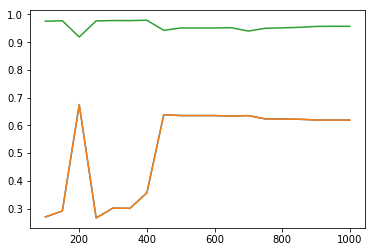

In [21]:
eta = [100,150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

plt.plot(eta,sens)
plt.plot(eta,accu)
plt.show()

In [57]:
param = {
    'max_depth': 20, 
    'eta': 500, 
    'silent': 1, 
    'objective': 'binary:logistic',
    'nthread': 4,
    'eval_metric': 'auc'
}
#param['nthread'] = 4
#param['eval_metric'] = ['auc', 'ams@0']

In [58]:
start_time = time.time()

num_round = 10
bst = xgb.train(param, dtrain, num_boost_round=num_round)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 71.49503684043884 seconds ---


In [59]:
pred_xgb = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

array([ 1.,  1.,  0., ...,  1.,  1.,  1.], dtype=float32)

In [60]:
conf_mat = confusion_matrix(y_val, pred_xgb.astype(int))
acc = (conf_mat[0][0] + conf_mat[1][1])/len(y_val)
print('Accuracy:', acc)

sen = conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1])
print('Sensitivity:', sen)

Accuracy: 0.951069918344
Sensitivity: 0.635494880546


** CV **

In [44]:
xgb_cv = xgb.cv(param, dtrain=dtrain, nfold=10, as_pandas=1, seed=rs)

In [62]:
xgb_cv

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.720290,0.008252,0.804476,0.002171
1,0.331308,0.009372,0.353701,0.010067
2,0.657591,0.012719,0.658986,0.010869
3,0.670683,0.041828,0.672633,0.043166
4,0.670683,0.041828,0.672633,0.043166
5,0.670683,0.041828,0.672633,0.043166
6,0.670683,0.041828,0.672633,0.043166
7,0.670683,0.041828,0.672633,0.043166
8,0.670683,0.041828,0.672633,0.043166
9,0.670683,0.041828,0.672633,0.043166


** GBT**

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
'''
param  = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting': 'gbdt',
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'feature_fraction_seed': rs,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'bagging_seed': rs,
    'num_boost_round': rounds
}
'''
start_time = time.time()

clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [39]:
pred = clf.predict(X_test)

In [41]:
conf_mat = confusion_matrix(y_test, pred)
acc = (conf_mat[0][0] + conf_mat[1][1])/len(y_test)
print('Accuracy:', acc)

sen = conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1])
print('Sensitivity:', sen)

Accuracy: 0.97923945124
Sensitivity: 0.366685616828


** Logistic Regression **

In [50]:
label = data.Is_Timely_response
X = normalize(data.drop('Is_Timely_response',1))

In [52]:
X = normalize(X)

In [54]:
pca = PCA(n_components=30)
pca.fit(X)
pca.components_.shape

(30, 277)

In [55]:
X_pca = pca.transform(X)
X_pca.shape

(860606, 30)

In [56]:
cols = []
for i in range(30):
    cols.append('PCA_%i'%(i+1))

X_pca = pd.DataFrame(X_pca)
X_pca.columns = cols

In [57]:
X_pca['Is_Timely_response'] = label
data_pca = X_pca

train_len = int(data_pca.shape[0] * 0.85)

train = data_pca.iloc[:train_len,:]
test = data_pca.iloc[train_len: ,:]

print('Training set shape:', train.shape)
print('Test set shape:', test.shape)

Training set shape: (731515, 31)
Test set shape: (129091, 31)


In [60]:
label.shape

(860606,)

In [61]:
label = train.Is_Timely_response
del train['Is_Timely_response']

X_train, X_val, y_train, y_val = train_test_split(
    train, label, 
    test_size = 0.15, 
    random_state = rs)

print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)

X_train shape: (621787, 30)
X_val shape: (109728, 30)
y_train shape: (621787,)
y_val shape: (109728,)


In [82]:
lr = LogisticRegression(random_state=rs)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=20171101, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [83]:
pred = lr.predict(X_val)

In [84]:
conf_mat = confusion_matrix(y_val, pred)
acc = (conf_mat[0][0] + conf_mat[1][1])/len(y_val)
print('Accuracy:', acc)

sen = conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1])
print('Sensitivity:', sen)

Accuracy: 0.9732702683
Sensitivity: 0.0


In [85]:
conf_mat

array([[     0,   2930],
       [     3, 106795]])

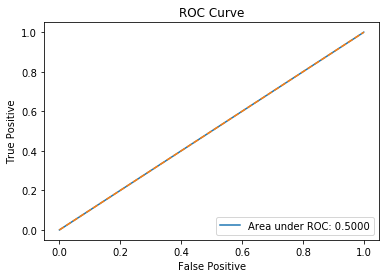

In [66]:
fp, tp, thr = roc_curve(y_val, pred)
score = roc_auc_score(y_val,pred)

plt.plot(fp, tp, label='Area under ROC: %0.4f'%score)
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.plot([0, 1], [0, 1], linestyle='--')

plt.show()